## Introduction

Here, we will be covering how to use xbatcher with Keras/Tensorflow. 

To start, let's import some libraries we'll need. The important libraries here are `numpy`, `xarray`, `xbatcher` and `tensorflow`, while most of the others aren't strictly necessary.

In [1]:
import numpy as np
import xarray as xr

from intake import open_catalog
from dataclasses import dataclass
from typing import Iterable

In [2]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
import tensorflow as tf

2023-01-31 00:53:37.108445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import xbatcher as xb

In [5]:
import itertools

## Designing Scenarios

We want to experiment with different neural network models by providing different inputs, and perhaps by playing with whether or not we run them through a convolutional layer. There are a lot of possibilities here, and if we approach it haphazardly, we'll end up with a mess of scattered experiments and results mixed in with other code. 

Instead, we can be more systematic about it. We know we want to define an individual scenario once, and then have it stay constant through the workflow. This way, there will be no surprises later on. With that in mind, we should use a `dataclass`. We want something minimal here, just enough to store the names of variables we're interested in. 

What is the structure of each experiment? We want some input variables to be run through a 2D convolutional layer, while some other inputs will be passed through directly to the dense part of the neural network. Both of these can be lists of strings, so we define `conv_var` and `input_var` as `Iterable[str]`.

Likewise, we have more than one target, so we define the `target` item as `Iterable[str]` as well. Outside of the `Scenario` dataclass, we define `target` as a list: `['U', 'V']`. Since we're only interested in learning the currents, this won't change.

Finally, we need to name each scenario something distinct, so when we create data subsets for training, testing, and prediction, we can recover them later.

In [6]:
@dataclass
class Scenario:
    conv_var: Iterable[str]
    input_var: Iterable[str]
    target: Iterable[str]
    name: str

In [7]:
target = ['U', 'V']

In [8]:
# Scenarios from 2d stencil notebook (re-expand maybe)
sc1 = Scenario(['SSH'],             ['TAUX', 'TAUY'], target, name = "derp")
sc5 = Scenario(['SSH', 'SST'], ['X', 'TAUX', 'TAUY'], target, name = "herp")

## Data and Preprocessing

For our dataset, we will be using ocean data from a high-resolution CESM POP model. 

We have some necessary I/O routines, but they aren't central to our problem, aside from the addtion of the new variables `X`, `Y`, `Z`, `dx` and `dy`, which represent Euclidean positions and distances between grid points.

You can have a look in the notebook below if you're curious about it.

In [9]:
%run ./surface_currents_prep.ipynb

From this notebook, we get a few new functions.

  * `prepare_data_2D` takes a scenario, as well as the time slices for training, testing, and prediction we are interested in, and the time slice we'll use for the NaN mask. It adds the new grid variables, and then stores each slice in a new zarr store that we can access later. This speeds up future I/O, which is helpful when modifying the model. Each scenario is stored separately.
  * `load_training_data` loads the training data created for the scenario passed to it.
  * `load_test_data` loads the testing data created for the scenario passed to it.
  * `load_predict_data` loads the prediction input data created for the scenario passed to it.
  
You can comment out `prepare_data_2D` after you've run it once, it will save time if you rerun the whole notebook again.

In [10]:
prepare_data_2D(sc5, 200, 1000, 1000, 200)

Next, we'll load our training data and pick out the part we want to train with. 

In [34]:
ds_training = load_training_data(sc5)
ds_training

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600)
Coordinates: (12/52)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
    time                object ...
    vonkar              float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    SSH                 (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    SST                 (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TAUX                (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TAUY                (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    U                   (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    V                   (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    X                   (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    mask                (nlat, nlon) bool dask.array<chunksize=(600, 900), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    contents:      Diagnostic and Prognostic Variables
    history:       none
    nsteps_total:  13088337
    revision:      $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy@ucar.edu $
    source:        CCSM POP2, the CCSM Ocean Component
    start_time:    This dataset was created on 2013-03-09 at 12:25:55.7
    tavg_sum:      86399.99999999962
    title:         hybrid_v5_rel04_BC5_ne120_t12_pop62

Looking inside `ds_training`, we see only the variables we would expect from `sc5`. 

In [12]:
ds_training = ds_training.isel(nlon=list(range(250,500)), nlat=list(range(1350,1650)))

In [13]:
ds_training

<xarray.Dataset>
Dimensions:             (nlat: 300, nlon: 250)
Coordinates: (12/52)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(300, 250), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(300, 250), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(300, 250), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(300, 250), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(300, 250), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(300, 250), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
    time                object ...
    vonkar              float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    SSH                 (nlat, nlon) float32 dask.array<chunksize=(300, 250), meta=np.ndarray>
    SST                 (nlat, nlon) float32 dask.array<chunksize=(300, 250), meta=np.ndarray>
    TAUX                (nlat, nlon) float32 dask.array<chunksize=(300, 250), meta=np.ndarray>
    TAUY                (nlat, nlon) float32 dask.array<chunksize=(300, 250), meta=np.ndarray>
    U                   (nlat, nlon) float32 dask.array<chunksize=(300, 250), meta=np.ndarray>
    V                   (nlat, nlon) float32 dask.array<chunksize=(300, 250), meta=np.ndarray>
    X                   (nlat, nlon) float64 dask.array<chunksize=(300, 250), meta=np.ndarray>
    mask                (nlat, nlon) bool dask.array<chunksize=(300, 250), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    contents:      Diagnostic and Prognostic Variables
    history:       none
    nsteps_total:  13088337
    revision:      $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy@ucar.edu $
    source:        CCSM POP2, the CCSM Ocean Component
    start_time:    This dataset was created on 2013-03-09 at 12:25:55.7
    tavg_sum:      86399.99999999962
    title:         hybrid_v5_rel04_BC5_ne120_t12_pop62

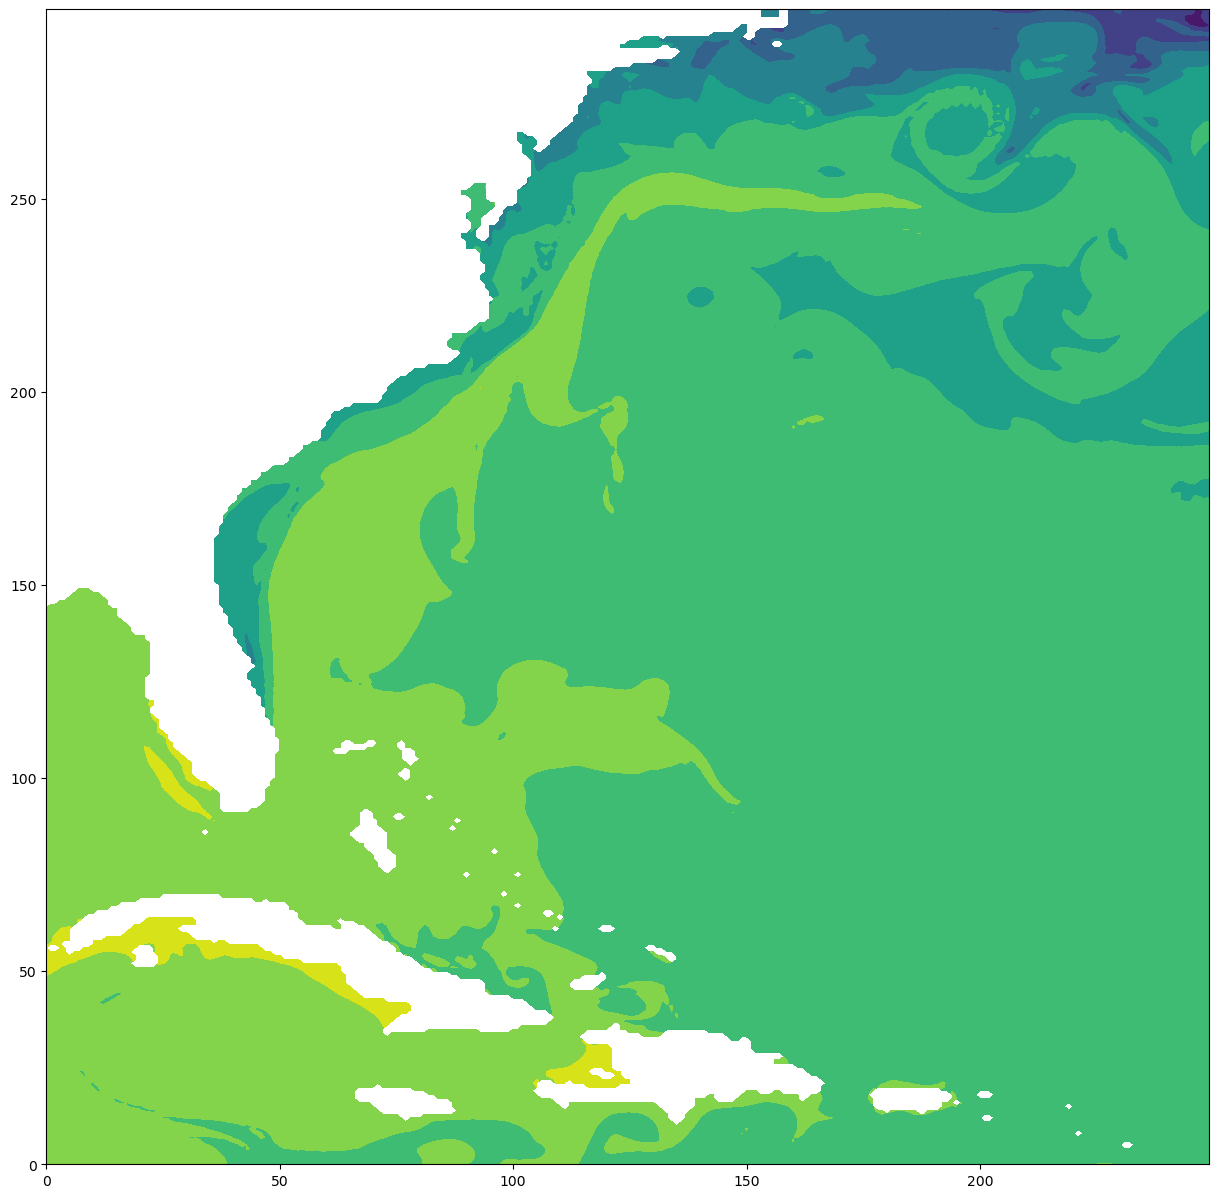

In [14]:

plt.figure(figsize=(15,15))
plt.contourf(ds_training['SST'])
plt.show()

In [15]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self, frequency=2048):
        self.frequency = frequency
        self.batch_counter = 0
        
        self.i = 0
        self.x = []
        self.mae = []
        self.mse = []
        self.accuracy = []
        self.logs = []
        
    def on_train_begin(self, logs={}):
        self.fig = plt.figure()
        
    def on_batch_end(self, batch, logs={}):
        # if batch % self.frequency == 0:
        self.batch_counter += self.frequency
        self.x.append(self.i)
        self.mae.append(logs.get('mae'))
        self.mse.append(logs.get('mse'))
        self.accuracy.append(logs.get('accuracy'))

        self.i += 1
            
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        clear_output(wait=True)
        print(f"MAE: {self.mae[-1]} \t\t MSE: {self.mse[-1]} \t\t Accuracy: {self.accuracy[-1]}")
        
        plt.figure(figsize=(18,5))

        plt.subplot(131)
        plt.plot(self.x, self.mae, color='#ff6347',label="mae")
        plt.plot(self.x[-1], self.mae[-1],marker = 'o', markersize=10, color='#ff6347')
        plt.legend()
        plt.xlabel(r'batch');
        plt.ylabel('Mean Absolute Error');
        plt.ylim([0.,100.])

        plt.subplot(132)
        plt.plot(self.x, self.mse, color='#6495ed')
        plt.plot(self.x[-1], self.mse[-1],marker = 'o', markersize=10, color='#6495ed')
        plt.xlabel('batch')
        plt.ylabel(r'Mean Squared Error [$cm^2/s^2$]')
        plt.ylim([0.,1000.])

        plt.subplot(133)
        plt.plot(self.x, self.accuracy, color='#3cb371')
        plt.plot(self.x[-1], self.accuracy[-1],marker = 'o', markersize=10, color='#3cb371')
        plt.xlabel('batch')
        plt.ylabel('Model Accuracy')
        plt.ylim([0.,1.])

        plt.show()

In [16]:
# Corner case: what happens when everything is NaN?
class Grid_MAE(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        avg = tf.math.abs(y_true - y_pred)
        masked = tf.where(tf.math.is_finite(avg), avg, tf.zeros_like(avg))
        return tf.math.reduce_sum(masked)

In [17]:
def get_model(halo_size, halo_dims, ds, sc, conv_dims, nfilters, conv_kernels, dense_layers):
    
    conv_init = tf.keras.Input(shape=tuple(conv_dims) + (len(sc.conv_var),))
    last_layer = conv_init
    for kernel in conv_kernels:
        this_layer = tf.keras.layers.Conv2D(nfilters, kernel)(last_layer)
        last_layer = this_layer
        nfilters = nfilters / 2.
    
    input_init = tf.keras.Input(shape=tuple(halo_dims) + (len(sc.input_var),))
    last_layer = tf.keras.layers.concatenate([last_layer, input_init])
    last_layer = tf.keras.layers.LeakyReLU(alpha=0.3)(last_layer)
    for layer in range(dense_layers):
        this_layer = tf.keras.layers.Dense(nfilters, activation='relu')(last_layer)
        last_layer = this_layer
        nfilters = nfilters / 2.
        
    output_layer = tf.keras.layers.Dense(len(sc.target))(last_layer)
    
    model = tf.keras.Model(inputs=[conv_init, input_init], outputs=output_layer)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss=Grid_MAE(), optimizer=opt, metrics=['mae', 'mse', 'accuracy'])
    model.summary()
    
    return model

In [43]:
def train(ds, sc, conv_dims=[3,3], nfilters=80, conv_kernels=[3], dense_layers=3):
    pars = locals()

    halo_size = int((np.sum(conv_kernels) - len(conv_kernels))/2)
    halo_dims = [x - 2*halo_size for x in conv_dims]
    
    nlons, nlats = conv_dims

    bgen = xb.BatchGenerator(
        ds,
        {'nlon':nlons,       'nlat':nlats},
        {'nlon':2*halo_size, 'nlat':2*halo_size},
        concat_input_dims=True
    )
    
    sub = {'nlon_input':range(halo_size,nlons-halo_size),
           'nlat_input':range(halo_size,nlats-halo_size)}

    model = get_model(halo_size, halo_dims, **pars)
    history = LossHistory()
    
    # def batcher(bgen, batch_size=32):
    #     i = 0
    #     while True:
    #         # print("{},\t\t{}".format(batch_size*i, batch_size*i + batch_size))
    #         yield xr.concat(itertools.islice(bgen, batch_size*i, batch_size*i + batch_size), dim='sample').transpose('sample', ...)
    #         i += 1
        
    # print(batcher(bgen))
    
    # b = batcher(bgen)
    
    for batch in bgen:
        
        batch_conv   = [batch[x] for x in sc.conv_var]
        batch_input  = [batch[x][sub] for x in sc.input_var]
        batch_target = [batch[x][sub] for x in sc.target]
        batch_conv   = xr.merge(batch_conv).to_array('var').transpose(...,'var')
        batch_input  = xr.merge(batch_input).to_array('var').transpose(...,'var')
        batch_target = xr.merge(batch_target).to_array('var').transpose(...,'var')
        
        clear_output(wait=True)
        model.fit([batch_conv, batch_input],
                  batch_target,
                  batch_size=32, epochs=4, verbose=0,
                  callbacks=[history])

    model.save('models/'+ sc.name)
    np.savez('models/history_'+sc.name, losses=history.mae, mse=history.mse, accuracy=history.accuracy)

    return model, history
    

In [ ]:
train(ds_training.fillna(0), sc5)